# Mediation analyses

Some proof-of-concept analyses to try to embed layer activations into shape shape and see whether this leads to better decoding of identity relative to decoding directly from the (compressed) layer activations.

In [1]:
import h5py
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = 'ResNet6'
dataset = 'gmf_112x112_emo'
target = 'shape'
epoch = '050'

# Different file for each layer
paths = sorted(list(Path('../results').glob(f'{model}_dataset-{dataset}_target-{target}_epoch-{epoch}_layer-*_preds.csv')))

For each layer, load in data and perform analysis.

In [2]:
results = defaultdict(list)  # to store results

# Loop over layers
for path in tqdm(paths):
    layer = path.name.split('layer-')[1].split('_preds')[0]
    
    # Load in train/val/test data; `a_N` = Neural activations
    with h5py.File('../trained_models/ResNet6_dataset-gmf_112x112_emo_target-shape/epoch-050_decomposed.h5', 'r') as f_in:
        X_test = f_in['testing']['a_N'][layer][:]  # N x 2048, where 2048 represents 2048 PCA-transformed layer activation components
        X_test_shape = f_in['testing']['shape'][:] # N x 354, where 394 represents the number of shape components from the GMF 
        Y_test = f_in['testing']['id'][:]  # N x 1, where 1 represents the integer ID corresponding to the face identity
        X_train = f_in['training']['a_N'][layer][:]
        X_train_shape = f_in['training']['shape'][:]
        X_val = f_in['validation']['a_N'][layer][:]
        X_val_shape = f_in['validation']['shape'][:]

    df = pd.read_csv(path)

    # Fit a model to predict shape from layer activations (which can used to later embed
    # the train and test set into shape space); we use ridge regression with cross-validation
    # to tune the alpha parameter
    alphas = np.logspace(-2, 6, num=9, endpoint=True)
    cv_scores = np.zeros((len(alphas), X_train_shape.shape[1]))
    for i, alpha in enumerate(alphas):
        model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
        model.fit(X_train, X_train_shape)
        preds = model.predict(X_val)
        cv_scores[i] = r2_score(X_val_shape, preds, multioutput='raw_values')

    # Infer best alphas *for each shape component separately* (huge difference compared to
    # picking a single alpha for all shape components) and use for final model
    best_alphas = alphas[cv_scores.argmax(axis=0)]
    model = make_pipeline(StandardScaler(), Ridge(alpha=best_alphas))
    model.fit(X_train, X_train_shape)  # final (re)fit on all data

    # Perform 4-fold cross-validation analysis (predicting ID) on the test set using
    # either the original layer activations (preds_direct) or the activations embedded
    # into shape space (preds_embed)
    cv = StratifiedKFold(n_splits=4)
    # We use LDA because it's a lot faster than e.g. logistic regression
    id_model = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(solver='lsqr'))
    preds_direct = np.zeros((Y_test.shape[0], np.unique(Y_test).size))
    preds_embed = np.zeros((Y_test.shape[0], np.unique(Y_test).size))
    
    for train_idx, test_idx in cv.split(X_test, Y_test):
        # Fit direct model (id_model)
        id_model.fit(X_test[train_idx], Y_test[train_idx])
        preds_direct[test_idx] = id_model.predict_proba(X_test[test_idx])
        
        # Embed data into shape space (X_) and predict ID
        X_ = model.predict(X_test)
        id_model.fit(X_[train_idx], Y_test[train_idx])
        preds_embed[test_idx] = id_model.predict_proba(X_[test_idx])

    # Compute AUC scores for both models on all predictions at the same time
    score_direct = roc_auc_score(Y_test, preds_direct, multi_class='ovr')
    score_embed = roc_auc_score(Y_test, preds_embed, multi_class='ovr')
    
    # Store results
    for score, type_ in [(score_direct, 'direct'), (score_embed, 'embed')]:
        results['layer'].append(layer)
        results['score'].append(score)
        results['type'].append(type_)

100%|██████████| 8/8 [27:45<00:00, 208.20s/it]


Simple bar plot to compare:

<AxesSubplot: xlabel='layer', ylabel='score'>

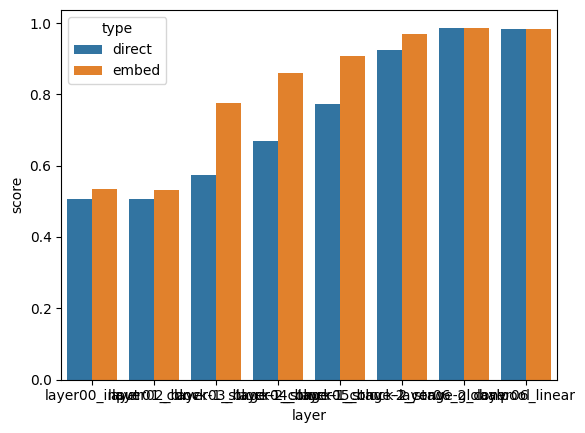

In [3]:
df = pd.DataFrame(results)
sns.barplot(x='layer', y='score', hue='type', data=df)